In [66]:
import torch
from icecream import ic
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with open('checkpoints/pendulum/goku_model.pkl', 'rb') as f:
    ckpt = torch.load(f, weights_only=False)
with open('data/pendulum/processed_data.pkl', 'rb') as processed_data_file:
    x = torch.load(processed_data_file, weights_only=False)
test_data = x['test']
train_data = x['train']
args = ckpt['args']   # saved argparse.Namespace
model_state = ckpt['model']
data_args = ckpt.get('data_args', None)


In [72]:
print(ckpt.keys())
print(x.keys())

ic| ckpt.keys(): dict_keys(['args', 'model', 'data_args', 'opt', 'epoch', 'best_val_loss'])
ic| x.keys(): dict_keys(['train', 'test'])


dict_keys(['train', 'test'])

In [67]:
# --- build model and load weights ---
print(train_data.shape)
print(test_data.shape)

ic| train_data.shape: (450, 100, 28, 28)
ic| test_data.shape: (50, 100, 28, 28)


(50, 100, 28, 28)

In [68]:
with open('data/pendulum/data_args.pkl', 'rb') as data_args:
    data_args = torch.load(data_args, weights_only=False)
ic(data_args)

ic| data_args: {'mask_rate': 0.01, 'model': 'pendulum', 'noise_std': 0.0}


{'mask_rate': 0.01, 'noise_std': 0.0, 'model': 'pendulum'}

In [69]:
import inspect
from models.GOKU import GOKU
from models.GOKU import create_goku_pendulum
sig = inspect.signature(create_goku_pendulum)
print(sig)
# parameter defaults (including kw-only)
spec = inspect.getfullargspec(create_goku_pendulum)
defaults = {}
if spec.defaults:
    defaults.update({name: val for name, val in zip(spec.args[-len(spec.defaults):], spec.defaults)})
if spec.kwonlydefaults:
    defaults.update(spec.kwonlydefaults)
print("defaults:", defaults)

ic| sig: <Signature (input_dim=[28, 28], latent_dim=16, rnn_input_dim=32, rnn_output_dim=16, ode_method='rk4', rnn_dropout=0.0, rnn_layers=2)>
ic| "defaults:": 'defaults:'
    defaults: {'input_dim': [28, 28],
               'latent_dim': 16,
               'ode_method': 'rk4',
               'rnn_dropout': 0.0,
               'rnn_input_dim': 32,
               'rnn_layers': 2,
               'rnn_output_dim': 16}


('defaults:',
 {'input_dim': [28, 28],
  'latent_dim': 16,
  'rnn_input_dim': 32,
  'rnn_output_dim': 16,
  'ode_method': 'rk4',
  'rnn_dropout': 0.0,
  'rnn_layers': 2})

In [73]:
import models.GOKU_pendulum as GOKU_pendulum
goku = GOKU(**defaults, encoder=GOKU_pendulum.Encoder, decoder=GOKU_pendulum.Decoder)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # change to whatever optimizer was used
model.load_state_dict(model_state)
optimizer.load_state_dict(ckpt['opt'])


In [ ]:
# python
# make sure names and device match
goku = goku.to(device)                  # your model instance


# EVALUATE on test set (robust to common shape layouts)
goku.eval()
x = torch.as_tensor(test_data).float().to(device)   # (N,T,...) or (T,N,...)
# # try to make layout (N,T,features)
# if x.ndim > 2 and x.shape[0] == args.seq_len and x.shape[1] != args.seq_len:
#     x = x.permute(1,0,*range(2,x.ndim))
# if x.ndim > 2 and x.shape[2:] != ():
#     x = x.view(x.shape[0], x.shape[1], -1)

# time array (use saved args if available)
delta_t = getattr(args, 'delta_t', 1.0)
seq_len = x.shape[1]
t = torch.arange(0.0, seq_len * float(delta_t), step=float(delta_t), device=device)

with torch.no_grad():
    out = goku(x, t=t, variational=False)
    pred = out[0] if isinstance(out, tuple) else out

# undo normalization if data_args present (zscore or minmax)
def undo_norm(z, data_args):
    if not data_args: return z
    norm = data_args.get('norm', None)
    if norm == 'zscore' and 'x_mean' in data_args and 'x_std' in data_args:
        mean = torch.as_tensor(data_args['x_mean'], device=z.device).view(1,1,-1)
        std  = torch.as_tensor(data_args['x_std'], device=z.device).view(1,1,-1)
        return z * std + mean
    if norm in ('zero_to_one','minmax') and 'x_min' in data_args and 'x_max' in data_args:
        mn = torch.as_tensor(data_args['x_min'], device=z.device).view(1,1,-1)
        mx = torch.as_tensor(data_args['x_max'], device=z.device).view(1,1,-1)
        return z * (mx - mn) + mn
    return z

pred = undo_norm(pred, data_args)
true = undo_norm(x, data_args)

# compute per-timestep MAE / RMSE (average over all axes except time)
time_dim = 1 if pred.shape[1] == seq_len else 0
reduce_dims = tuple(i for i in range(pred.ndim) if i != time_dim)
err = pred - true
mae_per_t = err.abs().mean(dim=reduce_dims).cpu().numpy()
rmse_per_t = err.pow(2).mean(dim=reduce_dims).sqrt().cpu().numpy()

print("Mean MAE:", mae_per_t.mean(), "Mean RMSE:", rmse_per_t.mean())

ic| "Mean MAE:": 'Mean MAE:'
    mae_per_t.mean(): 0.088218644
    "Mean RMSE:": 'Mean RMSE:'
    rmse_per_t.mean(): 0.21841006


('Mean MAE:', 0.088218644, 'Mean RMSE:', 0.21841006)

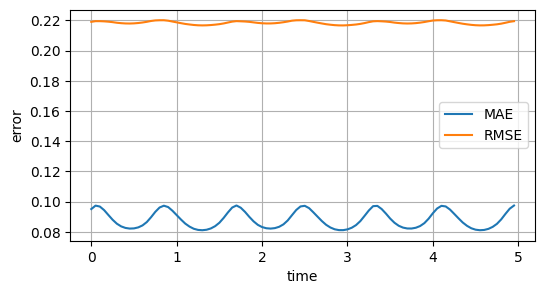

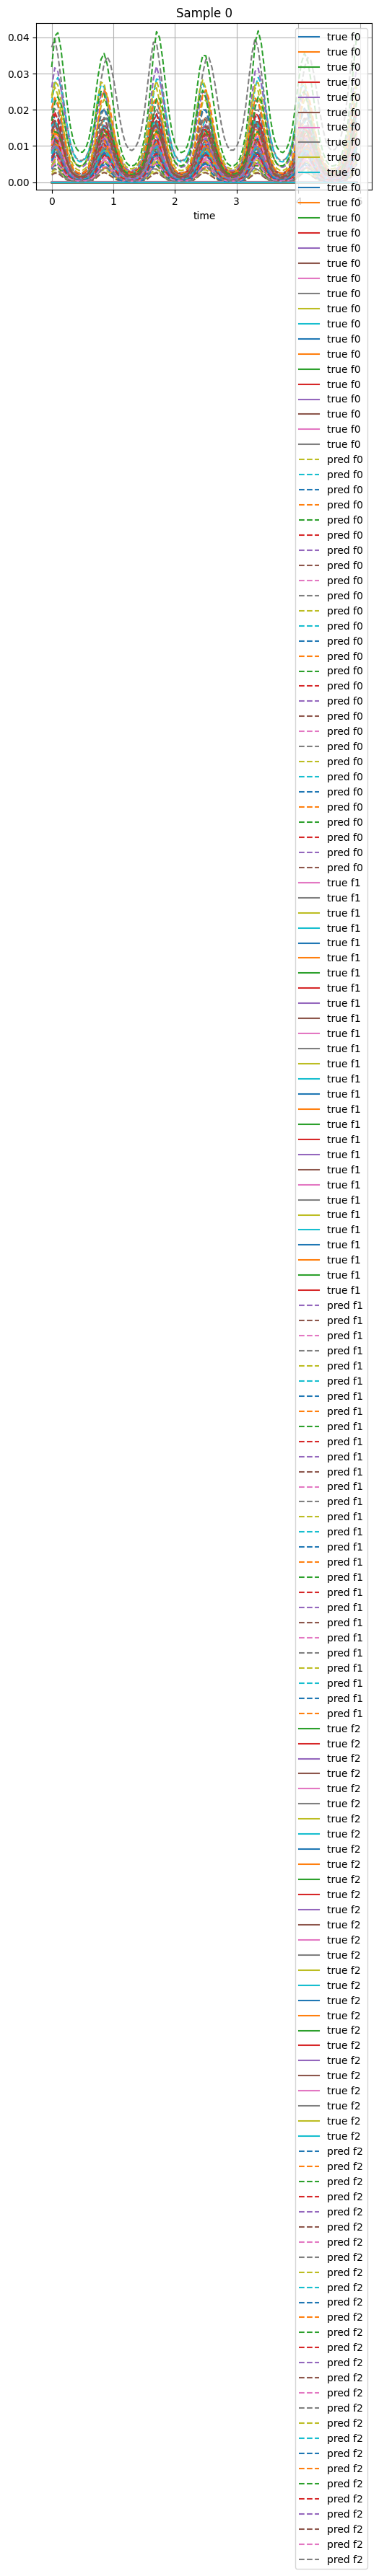

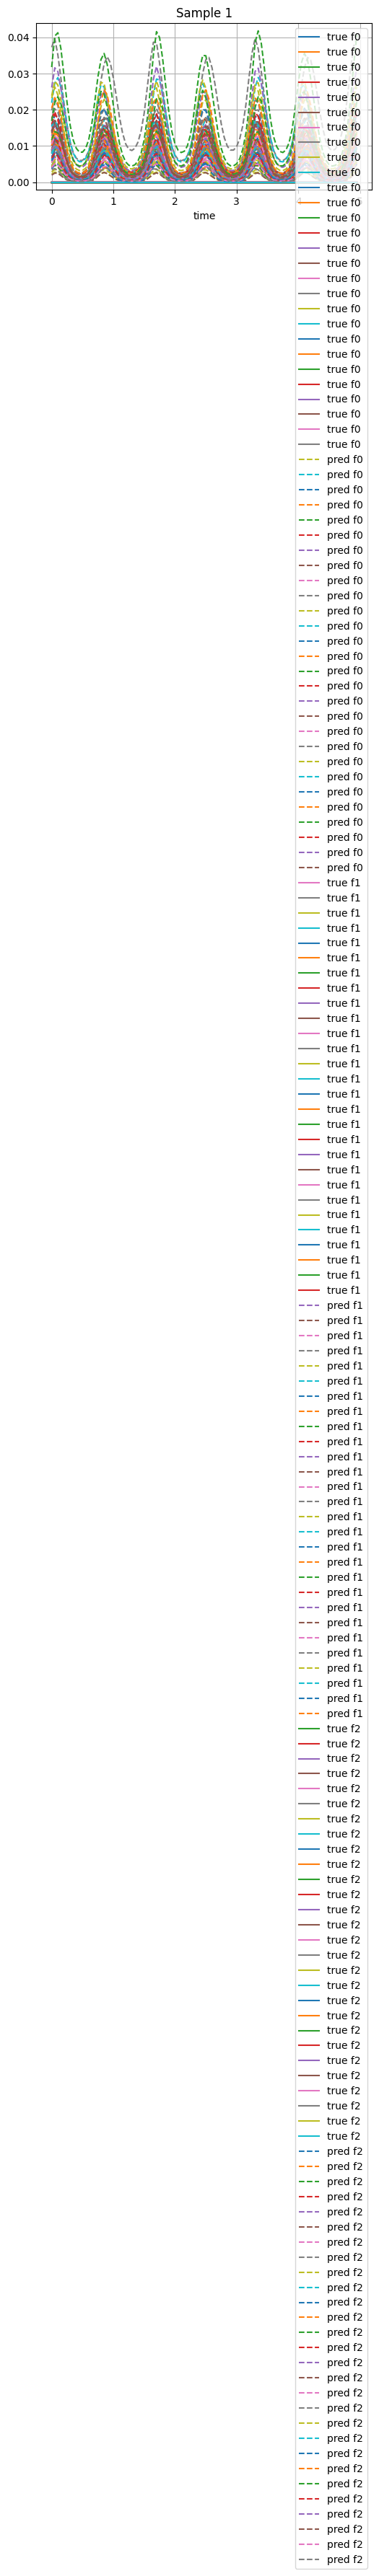

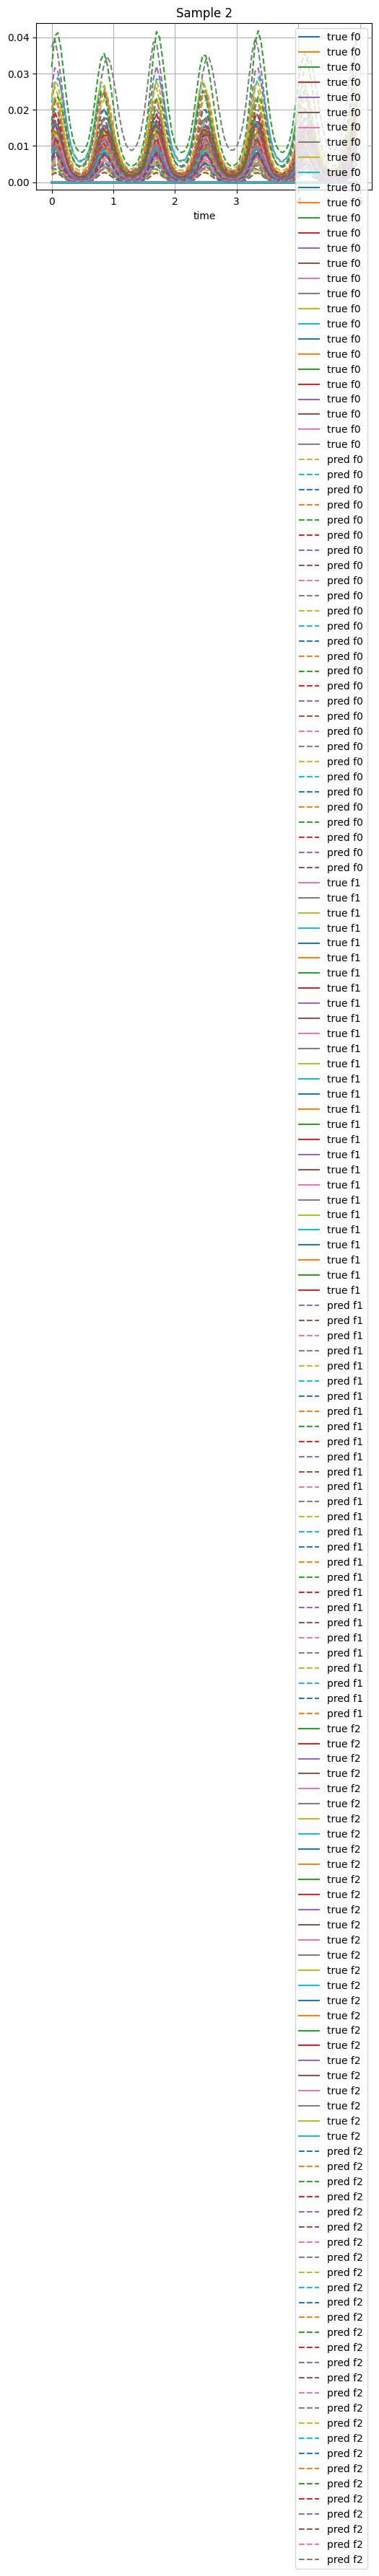

In [81]:
# quick plotting
time = np.arange(seq_len) * float(delta_t)
plt.figure(figsize=(6,3))
plt.plot(time, mae_per_t, label='MAE')
plt.plot(time, rmse_per_t, label='RMSE')
plt.xlabel('time'); plt.ylabel('error'); plt.legend(); plt.grid(True); plt.show()

# sample trajectories (up to 3 samples x 3 features)
pred_np = pred.detach().cpu().numpy()
true_np = true.detach().cpu().numpy()
N = pred_np.shape[0]; feats = pred_np.shape[2] if pred_np.ndim > 2 else 1
for s in range(min(3, N)):
    plt.figure(figsize=(6,3))
    for f in range(min(3, feats)):
        plt.plot(time, true_np[s,:,f] if feats>1 else true_np[s,:], label=f"true f{f}")
        plt.plot(time, pred_np[s,:,f] if feats>1 else pred_np[s,:], '--', label=f"pred f{f}")
    plt.title(f"Sample {s}"); plt.xlabel("time"); plt.legend(); plt.grid(True); plt.show()
# ...existing code...